# Write project_config.py

In [1]:
%%writefile project_config.py
import os


#configure path
parent=os.path.dirname(os.getcwd())
input_loc=os.path.join(parent,"input")
model_path=os.path.join(parent,"models")
output_path=os.path.join(parent,"output")

#raw data which is saed in input_loc
call_file="Seattle_Real_Time_Fire_911_Calls.csv"
weather_file="weather_2017_2022.csv"

#limits for data loading, mem_limit specifies maximum allowed data size to be loaded
mem_limit=1000
starting_year=2017
last_year=2022

#configure features
train_features=['year', 'month', 'day', 'hour', 'week','PRCP', 'SNOW', 'SNWD','TMAX', 'TMIN']
target_features=["volume"]

#configure grid search and splits. Number of splits in cross validation
#number of iterations in random search and neighbourhood of best parameters for 
#subsequent grid search
time_cv_split=5
random_iter=2
perc=0.20

#parameter grid for random search
param_grid={
    'n_estimators': [100],
    'min_samples_split': [2],
    'min_samples_leaf': [4 ],
    'max_features': [1],
    'max_depth': [10]
}

Overwriting project_config.py


# Write Preprocessing.py

Preprocessing.py is for loading the raw csv data and subsequent processing. In Addition to the Seattle data, I added daily weather data from NOAA. The meassurements were made at a weather station close to Seattle. When run, the script will save the train and test data as csv into the input folder.

In [2]:
%%writefile preprocessing.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from project_config import parent, input_loc, call_file, weather_file
from project_config import mem_limit, starting_year, last_year


# input directory, contains training and testing data
call_data=os.path.join(input_loc,call_file)
weather_data=os.path.join(input_loc, weather_file)
all_data=[call_data,weather_data]

#filzesize warning
for data in all_data:
    file_stats=os.stat(data)
    print('File Size in MegaBytes is {}'.format(file_stats.st_size / (1024 * 1024)))
    assert file_stats.st_size / (1024 * 1024) < mem_limit , "File too big"





def date_formatter(df,date_name,temp=["year","month","week","day","hour"]):
    '''
    create relevant time columns
    '''
    
    all_formats=["year","month","week","day","hour"]
    assert date_name in df.columns , "Date column does not exist"
    assert all([True if x in all_formats else False for x in temp]), "Non available time format"
    
    #convert to datetime object
    df[date_name]=pd.to_datetime(df[date_name])
    
    for _format in temp:
        if _format=="year":
            df[_format]=df[date_name].dt.year
        elif _format=="month":
            df[_format]=df[date_name].dt.month
        elif _format=="week":
            df[_format]=df[date_name].dt.weekday
        elif _format=="day":
            df[_format]=df[date_name].dt.day
        elif _format=="hour":
            df[_format]=df[date_name].dt.hour
    
    return df


# read data
em_data= pd.read_csv(call_data)
we_data= pd.read_csv(weather_data)

#format dates
em_data=date_formatter(em_data,"Datetime",["year","month","week","day","hour"])
# only keep relevant columns
em_data.drop(["Address", "Type","Latitude", "Longitude","Report Location", 
              "Incident Number","Datetime"], axis=1,inplace=True)
em_data.dropna(inplace=True)
em_data=em_data.loc[em_data["year"]>=starting_year].copy()

# create call volume columns as label for training, coarseness set to hour
volume=em_data.value_counts(sort=False).values.copy()
em_data.drop_duplicates(inplace=True)
em_data.loc[:,"volume"]=volume



# repeat for weather data
we_data=date_formatter(we_data,"DATE",["year","month","week","day"])
we_data=we_data.drop(["STATION","DAPR",'DAPR_ATTRIBUTES',"MDPR",'MDPR_ATTRIBUTES','PRCP_ATTRIBUTES',
                     'TOBS', 'TOBS_ATTRIBUTES', 'WT01', 'WT01_ATTRIBUTES', 'WT06',
       'WT06_ATTRIBUTES', 'WT11', 'WT11_ATTRIBUTES','SNOW_ATTRIBUTES','SNWD_ATTRIBUTES',
                      'TMAX_ATTRIBUTES','TMIN_ATTRIBUTES','DATE'], axis=1)
we_data.fillna(method="pad", inplace=True)

# reduce variance through log scaling
we_data["PRCP"]=we_data.loc[:,"PRCP"].apply(lambda x: np.log(1+x))
we_data["SNWD"]=we_data.loc[:,"SNWD"].apply(lambda x: np.log(1+x))


# merge weather data and call data
merged_data=em_data.copy()
merged_data=merged_data.merge(we_data, how="outer")
merged_data.sort_values(by=['year','month','day','hour'], inplace=True)
merged_data.fillna(method="pad", inplace=True)
merged_data.reset_index(drop=True, inplace=True)


# only keep last 5 years for training and testing
train_data=merged_data.loc[merged_data["year"]<last_year]
test_data=merged_data.loc[merged_data["year"]==last_year]


train_data.to_csv(os.path.join(input_loc,"train.csv"), index=False)
test_data.to_csv(os.path.join(input_loc,"test.csv"), index=False)

File Size in MegaBytes is 191.88097953796387
File Size in MegaBytes is 0.24791526794433594


# Write model.py

Model.py provides a class for the sklearn RandomForest regression model. The RF_Model class inherits from an extendable metric and data_loader class and provides apart from prediction/training a method for hyperparameter search. The class provides random search and grid search, aswell as a combined method, where a random search is first performed, followed by a grid search in the vicinity of the best parameter set. The vicinity is set through the perc parameters, which indicates the percentage of derivation from the best parameters found through the random search in the first step.

In [5]:
%%writefile model.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from project_config import parent

class metrics(object):
    '''
    class containing metrics for evaluation
    '''
    def MAE(self,X,Y):
        return np.abs(X-Y).mean()
    
class data_loader(object):
    '''
    Load prepared train and test data
    
    train_features: column names of train.csv used for training
    target_features: ""
    path: provide path where train.csv and test.csv are locaated
    '''
    def load_train_test(self,train_features=['year', 'month', 'day', 'hour', 'week',
                        'PRCP', 'SNOW', 'SNWD','TMAX', 'TMIN'],
                        target_features=["volume"],
                        path=""):
        
        if len(path)==0:
            parent=os.path.dirname(os.getcwd())
            path=os.path.join(parent,"input")
        
        train=pd.read_csv(os.path.join(path, "train.csv"))
        test=pd.read_csv(os.path.join(path, "test.csv"))
        
        # avoid sklearn warnings
        # if only one column is fed as ["column"], pandas outputs a df and not a 1d Series
        if len(target_features)==1:
            target_features=target_features[0]
        if len(train_features)==1:
            train_features=train_features[0]
        
        train_x=train[train_features]
        train_y=train[target_features]

        test_x=test[train_features]
        test_y=test[target_features]
        
        return train_x, train_y, test_x, test_y

    
class RF_Model(metrics, data_loader):
    
    def __init__(self,parent=parent,params={}):
        '''
        initialize RF regressor
        
        Params: dictionary with RandomForest parameters
        '''
        self.parent=parent

        
        if len(params)==0:
            self.model = RandomForestRegressor()
        else:
            try:
                self.model = RandomForestRegressor(**params)
                print("initialized with params")
            except:
                print("non adequat parameters !")
        
    def train(self, X,Y):
        '''
        fit model to Data
        
        X: training data
        Y: training targets
        
        '''
        self.model.fit(X,Y)
    
    def predict_(self,X):
        '''
        make predictions
        
        X: Data array
        
        returns predictions
        '''
        self.forecast=self.model.predict(X)
        return self.forecast

    
    def evaluate(self,X,Y,metric="MAE"):
        '''
        compute metric
        '''
        if metric=="MAE":
            try:
                return self.MAE(self.forecast,Y)
            except:
                return self.MAE(self.model.predict(X),Y)
        else:
            print("metric not available")

    def time_cv_index(self,X,n_splits):
        '''
        compute indices for time series cross validation
        
        X: training data
        n_splits: number of splits for cross validation
        '''
        self.tscv = TimeSeriesSplit(n_splits=n_splits)
        self.CV=[]
        for train_index, test_index in self.tscv.split(X):
            self.CV.append((train_index, test_index))
        
    def random_search(self,X,Y,n_splits,iters,search_params,seed=0):
        '''
        perform random hypterparameter search
        
        X: training data
        Y: training targets
        n_splits: number of splits for cross validation
        iters: sampling iterations
        search_params: dictionary with parameters distributions
        seed: for reproducebility
        '''
        self.time_cv_index(X,n_splits)
        
        self.rs = RandomizedSearchCV(estimator=self.model, param_distributions=search_params,
                                     cv=self.CV,scoring="neg_mean_absolute_error", 
                         random_state=seed, refit="neg_mean_absolute_error", n_iter=iters)
        
        self.rs_results = self.rs.fit(X, Y)
        self.model=self.rs.best_estimator_
        
    def grid_search(self,X,Y,n_splits, search_params):
        '''
        perform grid search
        
        X: training data
        Y: training targets
        n_splits: number of splits for cross validation
        search_params: dictionary with parameters 
        
        Might take long!
        
        '''
        self.time_cv_index(X,n_splits)
        self.gs = GridSearchCV(estimator=self.model, param_grid=search_params,
                               cv=self.CV,scoring="neg_mean_absolute_error", refit="neg_mean_absolute_error")
        self.gs_results=self.gs.fit(X,Y)
        self.model=self.gs.best_estimator_
        
    def Hyper_opt(self,X,Y,n_splits,iters,search_params,perc=0.1,seed=0):
        '''
        perform random search and subsequent grid search in best_params neighbourhood
        perc: percentage of derivation from best param set found through random search, needed for grid search
        
        '''
        
        self.random_search(X,Y,n_splits,iters,search_params,seed)
        self.neighbour_grid={}
        
        for key in self.rs_results.best_params_.keys():
            self.neighbour_grid[key]=[int(self.rs_results.best_params_[key]*(1-perc)),
                                      self.rs_results.best_params_[key],
                            int(np.ceil(self.rs_results.best_params_[key]*(1+perc)))]
            
        self.grid_search(X,Y,n_splits,self.neighbour_grid)
        
    def save_model(self,path=""):
        '''
        saves model with pickle
        '''
        
        if len(path)==0:
            path=os.path.join(self.parent,"models")
            path=os.path.join(path,"RF_model.sav")
        
        pickle.dump(self.model, open(path, 'wb'))

        print("saved model to location: ", path)
        
    def load_model(self,path=""):
        '''
        Load model with pickle
        '''
        if len(path)==0:
            path=os.path.join(self.parent,"models")
            path=os.path.join(path,"best_RF_model.sav")
        
        self.model = pickle.load(open(path, 'rb'))
        

# Write train_and_opt.py

Here the training and optimization is done. Mostly using method from the RF_Model class. We have the freedom of choosing training features and the target for the regression through the column names of the train/test csv files. Also the parameter grid for the hyperparam optimization is defined here. The best model is saved to the model folder after it is refit to the whole training set. For demonstration purposes, the parameter grid is set fixed. 

In [3]:
%%writefile train_and_opt.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from model import RF_Model

# input directory, contains training and testing data
# select the features used for the model
# parameter grid for the random search
from project_config import parent, input_loc, output_path, model_path
from project_config import train_features, target_features
from project_config import time_cv_split, random_iter, perc, param_grid




# baseline
print("establish baseline model")
model=RF_Model(params={"n_estimators":100, "random_state":0})

# use dataloader method to get data
train_x,train_y, test_x, test_y=model.load_train_test(train_features=train_features,
                                                     target_features=target_features,path=input_loc)
        

# train naively on whole training set and evaluate on test set
model.train(train_x, train_y)
baseline_score=model.evaluate(test_x, test_y)
print("baseline MAE: " ,baseline_score)
model.save_model(path=os.path.join(model_path,"baseline_RF_model.sav"))

print("perform hyperparameter optimization")
model.Hyper_opt(X=train_x,Y=train_y,n_splits=2,iters=1,search_params=param_grid,perc=0.1,seed=0)
score_after_opt=model.evaluate(test_x, test_y)
print("optimized MAE: ",score_after_opt)
print("MAE reduction: {:0.4f}%. ".format(100*(score_after_opt-baseline_score)/baseline_score))
model.save_model(path=os.path.join(model_path,"best_RF_model.sav"))


establish baseline model
initialized with params
baseline MAE:  4.415839822024472
saved model to location:  /home/simon/Documents/niologic_code/models/baseline_RF_model.sav
perform hyperparameter optimization


/home/simon/anaconda3/envs/niologic/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
270 fits failed out of a total of 486.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/home/simon/anaconda3/envs/niologic/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/simon/anaconda3/envs/niologic/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "/home/simon/anaconda3/envs/niologic/lib/python3.11/site-packages/joblib/parallel.py", line 

optimized MAE:  4.320453456268433
MAE reduction: -2.1601%. 
saved model to location:  /home/simon/Documents/niologic_code/models/best_RF_model.sav


# Write Inference.py

We load the saved model and do predictions on the test set. 

MAE on test set  4.320453456268433


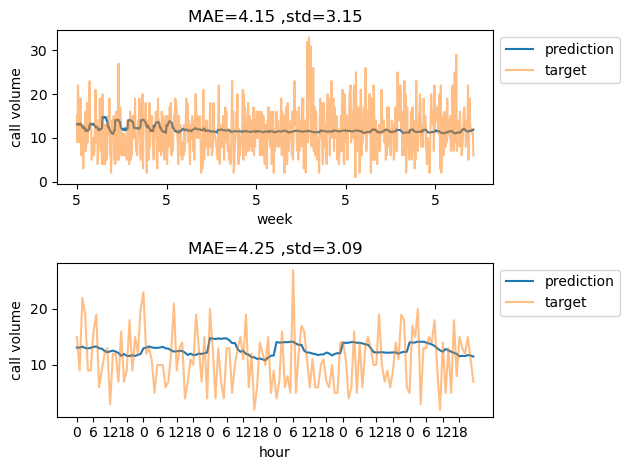

In [5]:
%%writefile inference.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from model import RF_Model

# define path where the models are loaded from
# select the features used for the model
from project_config import parent, input_loc, output_path, model_path
from project_config import train_features, target_features




model=RF_Model()
model.load_model()
_,_, test_x, test_y=model.load_train_test(train_features=train_features,
                                                     target_features=target_features,path=input_loc)

score=model.evaluate(test_x, test_y)
print("MAE on test set ", score)


# plot prediction for the first month of 2022 and the first week
m_pred=model.predict_(test_x[test_x['month']==1])
m_target=test_y[test_x['month']==1]
week=test_x.loc[test_x['month']==1,"week"]

w_pred=model.predict_(test_x[(test_x['month']==1) & (test_x["day"].between(0,6)) ])
w_target=test_y[(test_x['month']==1) & (test_x["day"].between(0,6)) ]
hours=test_x.loc[(test_x['month']==1) & (test_x["day"].between(0,6)), "hour"]


# save predictions
prediction_df=test_x.loc[test_x['month']==1,["year","month","day","hour"]].copy()
prediction_df["pred_volume"]=m_pred
prediction_df.to_csv(os.path.join(output_path,"prediction.csv"))

fig, ax=plt.subplots(2)
ax=ax.ravel()

ax[0].plot(m_pred, label='prediction')
ax[0].plot(m_target, alpha=0.5, label='target')
ax[0].set_xticks(range(0,len(m_pred),24*7))
ax[0].set_xticklabels(week.values[::24*7])
ax[0].set_xlabel("week")
ax[0].legend(bbox_to_anchor=(1., 1.0))
ax[0].set_title("MAE={} ,std={}".format(np.around(np.abs(m_pred-m_target).mean(),2),
                                        np.around(np.std(np.abs(m_pred-m_target)),2 )))

ax[1].plot(w_pred, label='prediction')
ax[1].plot(w_target,alpha=0.5, label='target')
ax[1].set_xticks(range(0,len(w_pred),6))
ax[1].set_xticklabels(hours.values[::6])
ax[1].set_xlabel("hour")
ax[1].legend(bbox_to_anchor=(1., 1.0))
ax[1].set_title("MAE={} ,std={}".format(np.around(np.abs(w_pred-w_target).mean(),2),
                                        np.around(np.std(np.abs(w_pred-w_target)),2 )))

ax[0].set_ylabel("call volume")
ax[1].set_ylabel("call volume")


plt.tight_layout()
plt.show()